In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [26]:
# Đọc file CSV
file_path = 'VCB_Historical_Data.csv'  # Đường dẫn đến file CSV của bạn
data = pd.read_csv(file_path)

# Chuyển đổi cột 'Date' thành datetime và sắp xếp dữ liệu
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
data.sort_values('Date', inplace=True)

data


,Date,Close,Open,High,Low,Vol.,Change %
0,2017-01-03,27643,26418,27828,26418,2580000,5.08%
1,2017-01-04,27457,27828,27903,27309,1710000,-0.67%
2,2017-01-05,27569,27383,27680,27346,1090000,0.41%
3,2017-01-06,28125,27606,28496,27531,3180000,2.02%
4,2017-01-09,28719,28348,28904,28274,3040000,2.11%
...,...,...,...,...,...,...,...
1736,2023-12-14,84400,84000,84500,84000,840600,0.84%
1737,2023-12-15,82200,84000,84400,82200,2530000,-2.61%
1738,2023-12-18,81500,82800,82900,81500,1800000,-0.85%
1739,2023-12-19,81200,81500,81500,80100,1960000,-0.37%


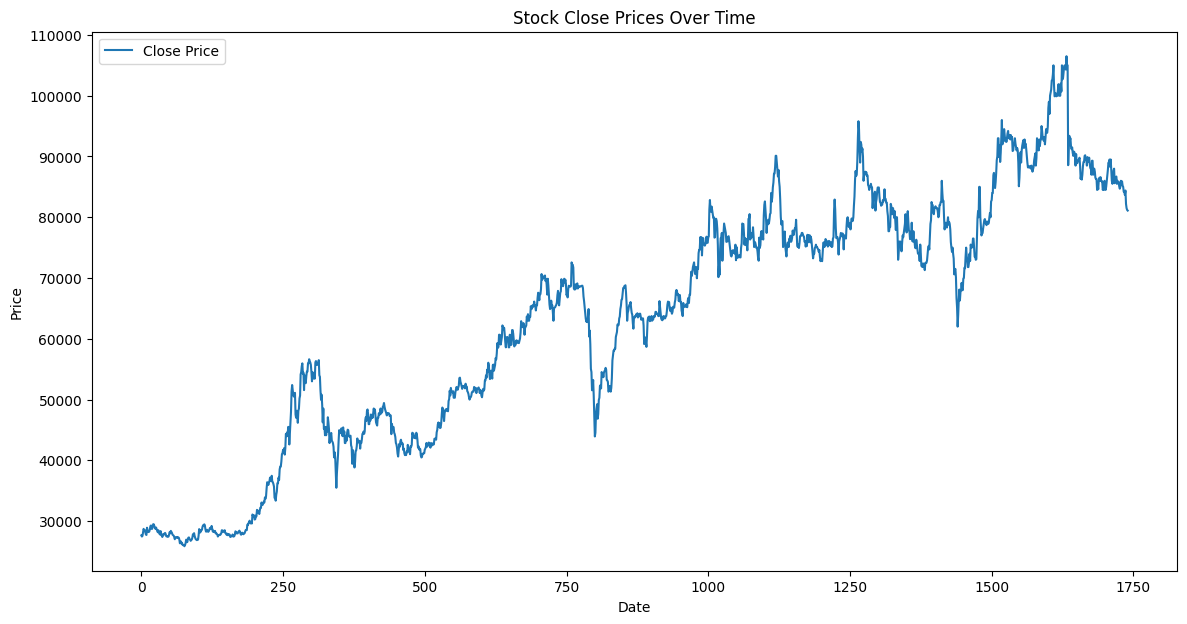

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [28]:
# Chọn 'Close' làm giá trị cần dự đoán
target = data['Close']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1)).reshape(-1)

# Chia dữ liệu thành tập train, test, và validate
train_size = int(len(scaled_target) * 0.6)
test_size = int(len(scaled_target) * 0.3)
train_data, remaining_data = scaled_target[:train_size], scaled_target[train_size:]
test_data, validate_data = train_test_split(remaining_data, test_size=test_size, shuffle=False)


In [29]:
# Chọn 'Close' làm giá trị cần dự đoán
target = data['Close']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1)).reshape(-1)

# Chia dữ liệu thành tập train, test, và validate
train_size = int(len(scaled_target) * 0.5)
test_size = int(len(scaled_target) * 0.3)
train_data, remaining_data = scaled_target[:train_size], scaled_target[train_size:]
test_data, validate_data = train_test_split(remaining_data, test_size=test_size, shuffle=False)


In [30]:
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        X.append(a)
        Y.append(dataset[i + time_step])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_validate, y_validate = create_dataset(validate_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], 1)


In [31]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(100, 1)))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [32]:
model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=32)


Epoch 1/100
25/25 [==============================] - 5s 38ms/step - loss: 0.0120 - val_loss: 0.0048
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 6/100
25/25 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0079
Epoch 7/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
25/25 [==============================] - 0s 15ms/step - loss: 9.0356e-04 - val_loss: 0.0016
Epoch 9/100
25/25 [==============================] - 0s 17ms/step - loss: 7.8961e-04 - val_loss: 0.0016
Epoch 10/100
25/25 [==============================] - 0s 16ms/step - loss: 7.1865e-04 - val_

8/8 [==============================] - 1s 5ms/step
Test MAE: 1473.0803616431451, Test RMSE: 1899.1300699918272, Test MAPE: 1.9177275523180684%


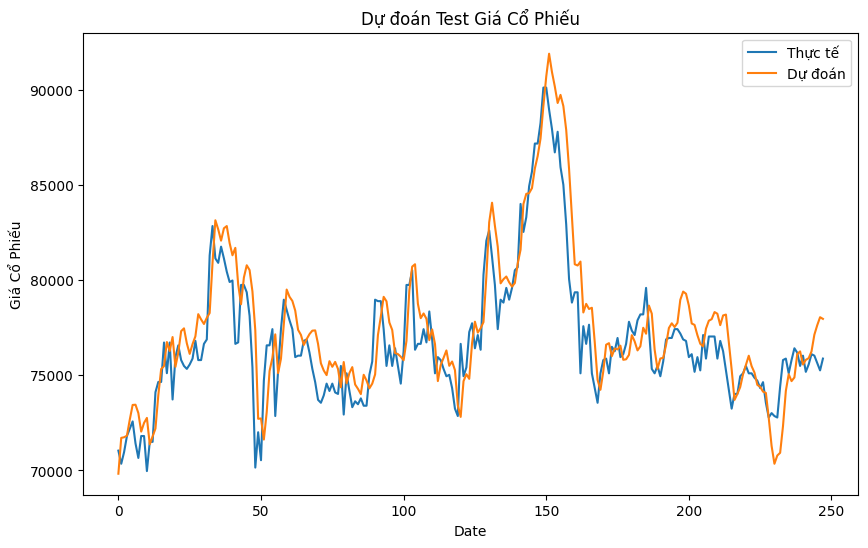

In [33]:
# Dự đoán trên tập test
test_predictions = model.predict(X_test)

# Chuyển đổi dự đoán và giá trị thực tế về dạng ban đầu
test_predictions_inverse = scaler.inverse_transform(test_predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính các chỉ số đánh giá
mae_test = mean_absolute_error(y_test_inverse, test_predictions_inverse)
rmse_test = np.sqrt(mean_squared_error(y_test_inverse, test_predictions_inverse))
mape_test = np.mean(np.abs((y_test_inverse - test_predictions_inverse) / y_test_inverse)) * 100

# In kết quả
print(f'Test MAE: {mae_test}, Test RMSE: {rmse_test}, Test MAPE: {mape_test}%')

# Visualize kết quả
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Thực tế')
plt.plot(test_predictions_inverse, label='Dự đoán')
plt.title('Dự đoán Test Giá Cổ Phiếu')
plt.xlabel('Date')
plt.ylabel('Giá Cổ Phiếu')
plt.legend()
plt.show()


14/14 [==============================] - 0s 5ms/step
Validate MAE: 1635.1528726247034, Validate RMSE: 2134.074646317781, Validate MAPE: 1.9467864919392113%


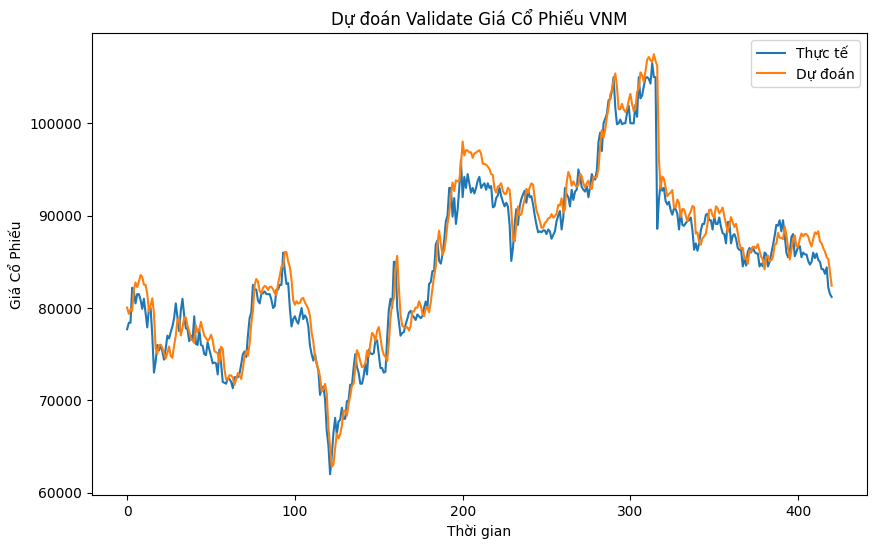

In [34]:
# Dự đoán trên tập validate
validate_predictions = model.predict(X_validate)

# Chuyển đổi dự đoán và giá trị thực tế về dạng ban đầu
validate_predictions_inverse = scaler.inverse_transform(validate_predictions)
y_validate_inverse = scaler.inverse_transform(y_validate.reshape(-1, 1))

# Tính các chỉ số đánh giá
mae_validate = mean_absolute_error(y_validate_inverse, validate_predictions_inverse)
rmse_validate = np.sqrt(mean_squared_error(y_validate_inverse, validate_predictions_inverse))
mape_validate = np.mean(np.abs((y_validate_inverse - validate_predictions_inverse) / y_validate_inverse)) * 100

# In kết quả
print(f'Validate MAE: {mae_validate}, Validate RMSE: {rmse_validate}, Validate MAPE: {mape_validate}%')

# Visualize kết quả
plt.figure(figsize=(10, 6))
plt.plot(y_validate_inverse, label='Thực tế')
plt.plot(validate_predictions_inverse, label='Dự đoán')
plt.title('Dự đoán Validate Giá Cổ Phiếu VNM')
plt.xlabel('Thời gian')
plt.ylabel('Giá Cổ Phiếu')
plt.legend()
plt.show()


In [35]:
# Chuẩn bị dữ liệu đầu vào cho việc dự đoán
last_data = scaled_target[-100:]  # Lấy 100 điểm dữ liệu cuối cùng
current_batch = last_data.reshape((1, 100, 1))

# Dự đoán cho 30 ngày tiếp theo
for i in range(30):
    # Dự đoán cho ngày tiếp theo
    pred_next = model.predict(current_batch)[0]
    # Cập nhật dữ liệu đầu vào
    current_batch = np.append(current_batch[:,1:,:], [[pred_next]], axis=1)

# Chuyển đổi kết quả dự đoán về dạng ban đầu
future_predictions = scaler.inverse_transform(current_batch.reshape(-1, 1))

# In kết quả dự đoán
print(future_predictions[30:])  # In ra 30 giá trị dự đoán mới nhất


1/1 [==============================] - 0s 127ms/step
[[84500.        ]
 [85000.        ]
 [85900.        ]
 [86800.        ]
 [87800.        ]
 [89000.        ]
 [88900.        ]
 [89500.        ]
 [88300.        ]
 [89500.        ]
 [87900.        ]
 [86000.        ]
 [85500.        ]
 [86000.        ]
 [87700.        ]
 [88000.        ]
 [85600.        ]
 [86100.        ]
 [86600.        ]
 [86700.        ]
 [85500.        ]
 [86000.        ]
 [85800.        ]
 [85800.        ]
 [85100.        ]
 [84700.        ]
 [85000.        ]
 [86000.        ]
 [85400.        ]
 [85900.        ]
 [85200.        ]
 [85000.        ]
 [84200.        ]
 [84200.        ]
 [83700.        ]
 [84400.        ]
 [82200.        ]
 [81500.        ]
 [81200.        ]
 [81100.        ]
 [81720.11792207]
 [81906.82731104]
 [82435.54565823]
 [82783.50013244]
 [83020.2393322 ]
 [83641.93266833]
 [83992.3528254 ]
 [84508.03141117]
 [84671.42976332]
 [84838.43772137]
 [85315.34308362]
 [85547.05959606]
 [85698.970

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


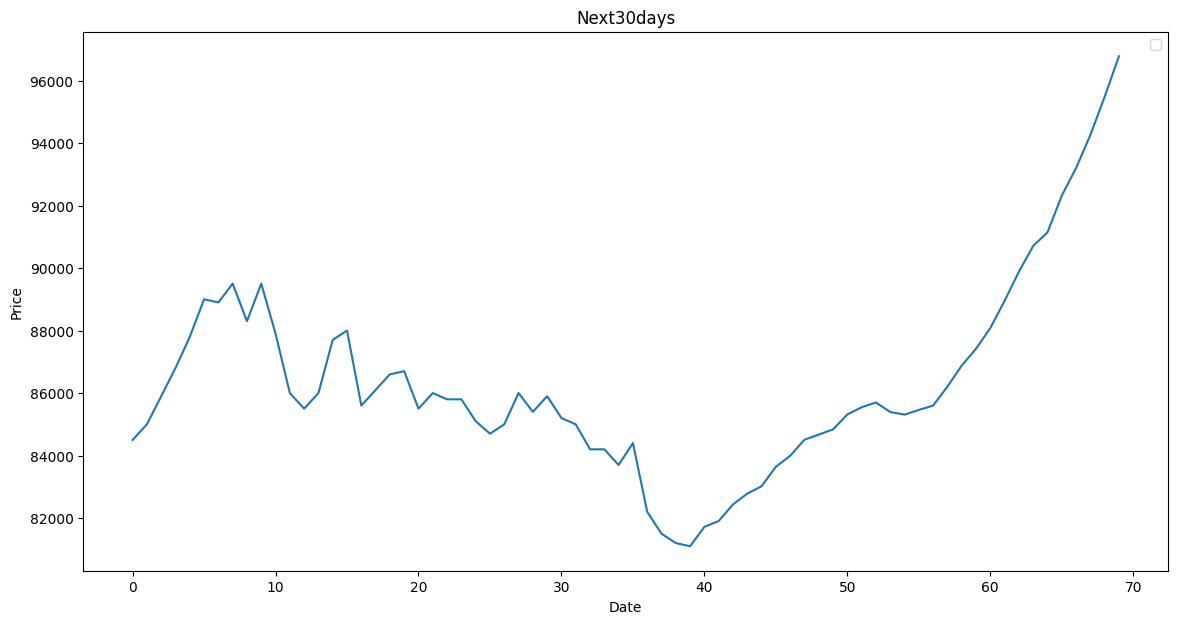

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(future_predictions[30:])
plt.title('Next30days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
